In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [103]:
data = pd.read_csv('../raw_data/PM/Met/xy_hc_fai_tstp_Me_4_PM.csv')
data.tail()

,Item1.Item1,Item1.Item2,Item1.Item3,Item1.Item4,Item1.Item5.Item1,Item1.Item5.Item2,Item1.Item5.Item3,Item1.Item6,Item2.Item1,Item2.Item2
218463,643.3001,879.2327,1.319749,39.01886,65.0,2.133521,True,837,0.3,2
218464,643.2682,879.3246,1.320216,39.01933,65.0,2.133521,True,840,0.3,2
218465,643.3392,879.3881,1.315297,39.01441,65.0,2.133521,True,844,0.3,2
218466,643.2624,879.3479,1.320209,39.01932,65.0,2.133521,True,847,0.3,2
218467,643.2950,879.2930,1.319168,39.01828,65.0,2.133521,True,852,0.3,2


In [104]:
data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']

In [106]:
data.head()

,X_coord,Y_coord,heading_direction,cumulative_direction,beat_freq,beat_amp,tail_move?,timestamp,contrast_level,flow_direction
0,620.6542,892.0280,0.719849,0.719849,32.5,1.057664,True,425,1.0,2
1,620.7598,891.9224,0.757939,0.757939,130.0,-1.380638,True,429,1.0,2
2,620.6842,891.9794,0.758545,0.758544,130.0,3.176747,True,432,1.0,2
3,620.7333,891.9125,0.759385,0.759385,130.0,3.176747,True,438,1.0,2
4,620.7429,891.8914,0.759881,0.759881,65.0,0.836423,True,442,1.0,2


In [107]:
data['contrast_level'].unique()

array([1.  , 0.  , 0.01, 0.1 , 0.3 , 0.5 , 0.7 , 0.2 ])

In [108]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

In [109]:
flow_to_right, flow_to_left = divide_data_by_flow_direction(data)

In [110]:
C0, C01, C1, C2, C3, C5, C7, C10 = divide_data_by_contrast(flow_to_left)

In [111]:
C10.head()

,X_coord,Y_coord,heading_direction,cumulative_direction,beat_freq,beat_amp,tail_move?,timestamp,contrast_level,flow_direction
0,620.6542,892.0280,0.719849,0.719849,32.5,1.057664,True,425,1.0,2
1,620.7598,891.9224,0.757939,0.757939,130.0,-1.380638,True,429,1.0,2
2,620.6842,891.9794,0.758545,0.758544,130.0,3.176747,True,432,1.0,2
3,620.7333,891.9125,0.759385,0.759385,130.0,3.176747,True,438,1.0,2
4,620.7429,891.8914,0.759881,0.759881,65.0,0.836423,True,442,1.0,2


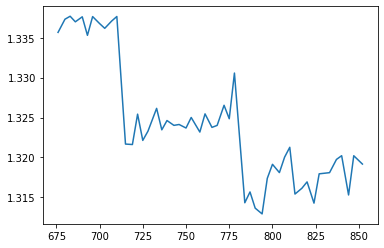

In [112]:
plt.plot(C3['timestamp'].tail(50),C3['heading_direction'].tail(50))

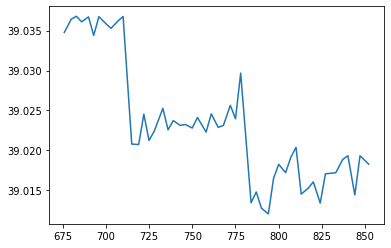

In [113]:
plt.plot(C3['timestamp'].tail(50),C3['cumulative_direction'].tail(50))

In [155]:
def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?','contrast_level','flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for row in range(len(new)-1):
        heading = new['heading_direction'][row]
        next_heading = new['heading_direction'][row+1]
        if np.abs(next_heading-heading) >= np.pi:
            next_heading = heading


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and adjusting all others
    
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']*10

    return interp

In [156]:
prep_LC1 = omr_preprocess(C1)
prep_LC1

,timestamp,X_coord,Y_coord,heading_direction,cumulative_direction,distance_pts
0,10,638.9368,783.4608,1.337118,0.00000,0.000000
1,20,638.9647,783.3606,1.336888,-0.00023,0.104012
2,30,638.8848,783.5364,1.339071,0.00196,0.193105
3,40,638.7903,783.8151,1.340756,0.00364,0.294285
4,50,638.8159,783.7244,1.340500,0.00339,0.094244
...,...,...,...,...,...,...
2995,29960,892.5365,722.9344,6.008899,-1.61140,0.141724
2996,29970,892.4893,722.9054,6.009731,-1.61057,0.055397
2997,29980,892.4420,722.9293,6.007755,-1.61254,0.052995
2998,29990,892.6053,722.9634,6.061750,-1.55855,0.166822


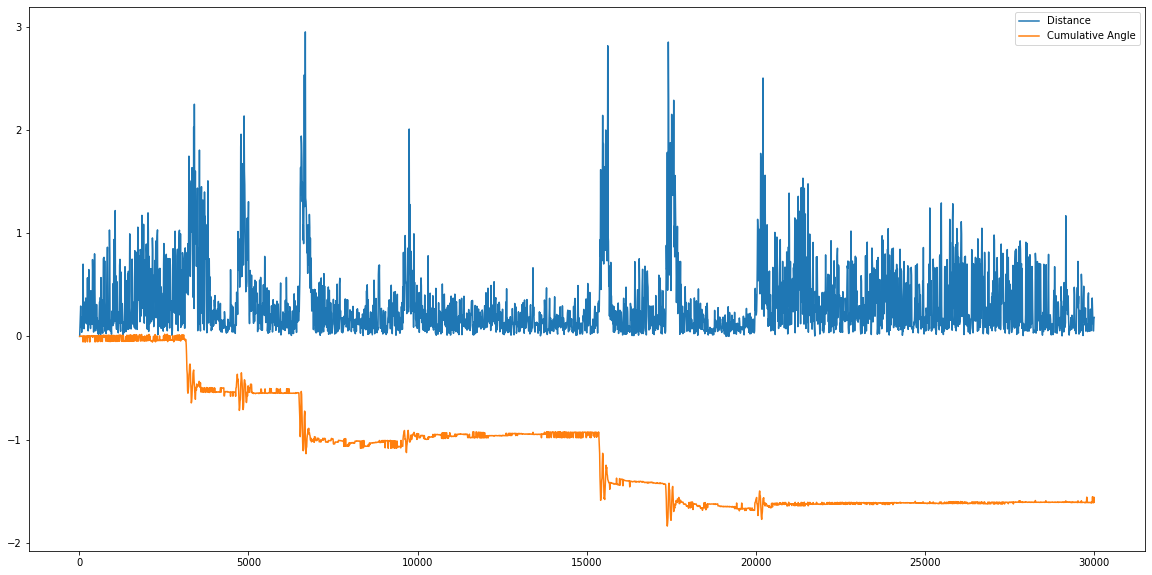

In [172]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(prep_LC1['timestamp'],prep_LC1['distance_pts'],label='Distance')
ax.plot(prep_LC1['timestamp'],prep_LC1['cumulative_direction'],label='Cumulative Angle')
# ax.set_ylim(20,20.3)
# ax.set_xlim(15000,20000)
plt.legend()
plt.show()